# OUProcess

## 1. Package Imports

In [1]:
using DifferentialEquations, Plots, Statistics

## 2. Ornstein-Uhlenbeck Ensemble Function

The '**OUFixedEnsemble**' function simulates an ensemble of trajectories of an Ornstein-Uhlenbeck (OU) process using stochastic differential equations (SDEs) with fixed time steps. The function takes several parameters to define the process and the simulation settings, runs the simulation, and returns the results. This description also includes subsequent steps for analyzing and plotting the empirical and analytical mean and covariance functions of the OU process.

### '**OUFixedEnsemble**' Function

#### Parameters:

- `θ` (Float64): The rate of mean reversion of the OU process.
  
- `μ` (Float64): The long-term mean towards which the process reverts.
  
- `σ` (Float64): The volatility parameter, representing the intensity of the random fluctuations.
  
- `u0` (Float64): The initial value of the process.
  
- `tspan` (Tuple{Float64, Float64}): The time span for the simulation, specified as a tuple (start time, end time).
  
- `dt` (Float64): The time step size for the simulation.
  
- `solver` (DiffEqBase.Solver): The solver to use for the SDE, e.g., Euler-Maruyama method (EM()).
  
- `samp` (Int): The number of trajectories (samples) to simulate.
  
- `reltol` (Float64): The relative tolerance for the solver.
  
- `abstol` (Float64): The absolute tolerance for the solver.
  
#### Returns:

- `sim` (EnsembleSolution): The solution object containing the simulated trajectories of the OU process.

In [2]:
# Define the OUFixedEnsemble function
function OUFixedEnsemble(θ, μ, σ, u0, tspan, dt, solver, samp, reltol, abstol)
    f(u, p, t) = θ * (μ - u)
    g(u, p, t) = σ
    
    prob = SDEProblem(f, g, u0, tspan)
    ensembleprob = EnsembleProblem(prob)
    sim = solve(ensembleprob, dt=dt, solver, EnsembleThreads(), trajectories=samp, abstol=abstol, reltol=reltol)
    return sim
end

OUFixedEnsemble (generic function with 1 method)

## 3. Parameters Setup

In [3]:
# Parameters
θ = 1
μ = 0.0
σ = sqrt(2)
u0 = 10.0
tf = 10
tspan = (0.0, tf)
saveint = 0.01
solver = EM()
samples = 1000
reltol = 1.0 * 10^(-6)
absol = 1.0 * 10^(-6)

1.0e-6

## 4. Run the Simulation

In [4]:
# Run the simulation
sim = OUFixedEnsemble(θ, μ, σ, u0, tspan, saveint, solver, samples, reltol, absol)

EnsembleSolution Solution of length 1000 with uType:
RODESolution{Float64, 1, Vector{Float64}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 1, Float64, Float64, Nothing, Nothing, typeof(DiffEqNoiseProcess.WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.WHITE_NOISE_BRIDGE), Nothing, false, ResettableStacks.ResettableStack{Tuple{Float64, Float64, Nothing}, false}, ResettableStacks.ResettableStack{Tuple{Float64, Float64, Nothing}, false}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Float64, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, Nothing, SDEFunction{false, SciMLBase.FullSpecialize, var"#f#1"{Int64, Float64}, var"#g#2"{Float64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, var"#g#2"{Float64}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, Nothing}, EM{true}, StochasticDiffEq.Linea

## 5. Analytical Mean Function

### '**analytical_mean**' Function
This function calculates the analytical mean of the Ornstein-Uhlenbeck (OU) process at a given time t. The parameters θ, μ, and u0 are defined in the OUFixedEnsemble function description.

#### Explanation:

The analytical_mean function computes the expected value of the OU process at time t using the formula: 

$$\mathbb{E}[X_t] = \mu + (X_0 - \mu) e^{-\theta t}$$

##### where:

- `t`: Time at which the mean is being calculated.

- `θ`: The rate of mean reversion.

- `μ`: The long-term mean.

- `X_0`: The initial value of the process (at time t=0)
 
This formula represents how the process evolves towards its long-term mean over time.

In [5]:
# Define the analytical mean function
function analytical_mean(t, θ, μ, u0)
    return μ + (u0 - μ) * exp(-θ * t)
end

analytical_mean (generic function with 1 method)

## 6. Compute and Plot Empirical and Analytical Mean

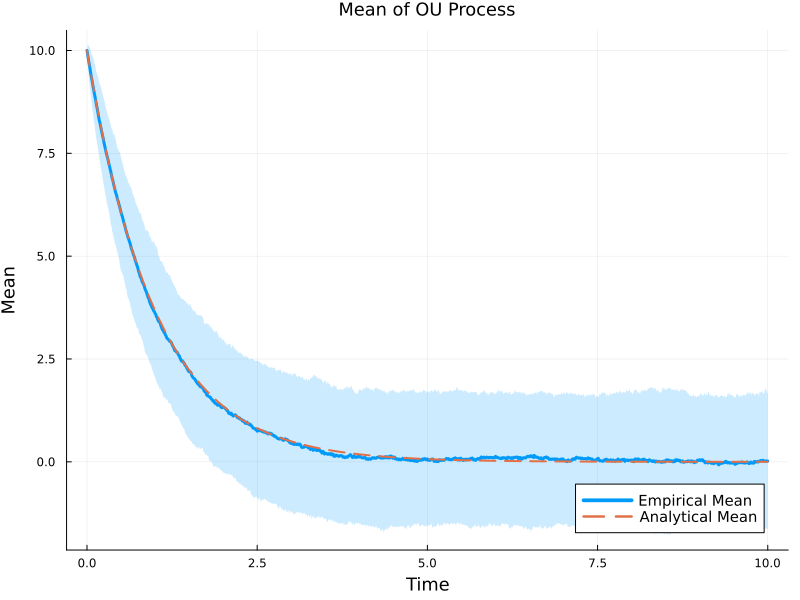

In [6]:
# Define the computational mean with shadow of spread
summ = EnsembleSummary(sim)

# Calculate the analytical mean for each time point
times = collect(range(0, step=saveint, length=length(sim[1].u)))
analytical_mean_trajectory = [analytical_mean(t, θ, μ, u0) for t in times]

# Plot the empirical mean and the analytical mean
plot(summ, label="Empirical Mean", xlabel="Time", ylabel="Mean", title="Mean of OU Process", legend=:bottomright, size=(800, 600), legendfontsize=10, titlefontsize=12, guidefontsize=12)
plot!(times, analytical_mean_trajectory, label="Analytical Mean", linestyle=:dash, linewidth=2)

## 7. Analytical Autocorrelation Function

### 'analytical_autocorrelation_function' Function
This function calculates the analytical autocorrelation of an Ornstein-Uhlenbeck (OU) process for a given time lag τ. The parameters τ, θ, and σ are used to compute the autocorrelation based on the theoretical properties of the OU process.

#### Explanation:

- `τ`: The time lag for which the covariance is being calculated.

- `θ`: The rate of mean reversion.

- `σ`: The volatility parameter, representing the intensity of the random fluctuations.
The function performs the following steps:

#### Calculate Analytical Autocorrelation:
- The analytical Autocorrelation is computed using the formula:
$$\text{Cov}(X_t, X_{t+\tau}) = \frac{\sigma^2}{2\theta} e^{-\theta |\tau|}$$
- This formula represents the autocorrelation between the values of the OU process at times t and t+τ.
  
The function returns the autocorrelation value for the given lag τ.

In [7]:
function analytical_autocorrelation_function(τ, θ, σ)
    return (σ^2 / (2 * θ)) * exp(-θ * abs(τ))
end

analytical_autocorrelation_function (generic function with 1 method)

## 8. Autocorrelation Function Approach One

### '**autocorrelation_function**' Function
This function computes the empirical autocorrelation function for an ensemble of Ornstein-Uhlenbeck (OU) process trajectories. The parameters 'trajectories_matrix', 'mean_trajectory', and 'max_lag' are used to calculate the autocorrelation for various time lags.

#### Explanation:

- `trajectories_matrix`: A matrix where each row represents a different trajectory and each column represents a time point.

- `mean_trajectory`: A vector representing the empirical mean of the trajectories at each time point.

- `max_lag`: The maximum lag (τ) for which the covariance is calculated.
The function performs the following steps:

#### Initialize Variables:

- `n`: The number of time points.

- `m`: The number of trajectories.

- `covariances`: A vector to store the covariance values for each lag τ.
  
- `diff_matrix`: A matrix of deviations from the mean trajectory for each time point.

#### Compute Covariances:

- For each lag τ from 0 to max_lag, it calculates the covariance between time points separated by τ.

- It iterates over all possible time points, ensuring that the lag does not exceed the time span.

#### Normalize Covariances:

- The covariance for each lag τ is averaged by the number of valid time point pairs.

- The covariances are then divided by the number of trajectories to get the final empirical covariance values.

- The covariance is then divided by the first element of this covariance vector inorder to give us our autocorrelation

This function returns a vector of autocorrelation values corresponding to each lag τ.


In [8]:
# Compute the covariance function
function autocorrelation_function(trajectories_matrix, mean_trajectory, max_lag)
    n = size(trajectories_matrix, 1)  # number of time points
    covariances = Vector{Float64}(undef, max_lag+1)
    diff_matrix = (trajectories_matrix.- mean_trajectory)
    
    for τ in 0:max_lag
        cov_τ = 0.0
        for t in 1:(n - τ)
            cov_τ += mean(diff_matrix[t, :].*diff_matrix[t+τ,:])
        end
        covariances[τ + 1] = cov_τ / (n - τ)
    end
    return covariances/covariances[1]
end

autocorrelation_function (generic function with 1 method)

## 9. Calculate and Plot Autocorrelation for Approach One

In [9]:
# Extracting the data
trajectories = [Array(sol) for sol in sim.u]

1000-element Vector{Vector{Float64}}:
 [10.0, 9.738869792418347, 9.619437442461782, 9.54872127153626, 9.33713433569715, 9.167604262818859, 8.94832232524465, 8.835984457432863, 8.654809036962186, 8.587245249668646  …  1.677053495603381, 2.0753494543963367, 2.0405729745748276, 1.8165282921437813, 1.6921403023691322, 1.7996669664945761, 1.8810829191543885, 1.9351512944191247, 1.7709730655349596, 1.70925776998994]
 [10.0, 10.113841535959276, 9.709686593074002, 9.568776742433744, 9.51407220889161, 9.382501418672394, 9.46382694927071, 9.278186974891643, 9.230709675747589, 9.098882045634825  …  1.0005799691530453, 0.8243673615327144, 1.0344203238964154, 1.0121028437152118, 0.9895195951925743, 0.9434416349366753, 1.1421306481517937, 1.1139885152906204, 1.3279159219573167, 1.591932703562313]
 [10.0, 9.843262402056416, 9.753813009124361, 9.926974406836308, 9.81255001210362, 9.816681987304655, 9.750151668797768, 9.504555726166485, 9.3500326974372, 9.158198652762385  …  0.3674688953084615, 0.29746

In [10]:
# Convert the list of trajectories into a matrix
trajectories_matrix = hcat(trajectories...)

1001×1000 Matrix{Float64}:
 10.0      10.0       10.0       …  10.0        10.0       10.0
  9.73887  10.1138     9.84326       9.78677    10.0596     9.80634
  9.61944   9.70969    9.75381       9.79443     9.9718     9.44377
  9.54872   9.56878    9.92697       9.71213     9.8403     9.52144
  9.33713   9.51407    9.81255       9.2719      9.897      9.71842
  9.1676    9.3825     9.81668   …   9.23944     9.88207    9.82178
  8.94832   9.46383    9.75015       9.24293     9.80881    9.88032
  8.83598   9.27819    9.50456       8.91293     9.82219    9.75244
  8.65481   9.23071    9.35003       8.59911    10.0109     9.8353
  8.58725   9.09888    9.1582        8.42319     9.89331    9.8745
  8.3718    9.00089    9.38419   …   8.57414     9.86361    9.82023
  8.26226   9.07153    9.25998       8.27543     9.85968    9.60065
  7.98733   9.3373     9.24935       8.31282     9.70197    9.46142
  ⋮                              ⋱                         
  1.63098   1.32115    0.339142    

In [11]:
# Calculate the maximum value for τ
max_lag = length(times) - 1

1000

In [12]:
# Calculate the computational autocorrelation for each tau
autocorrelation = autocorrelation_function(trajectories_matrix, summ, max_lag)

1001-element Vector{Float64}:
  1.0
  0.989883051872351
  0.9798806173997244
  0.9699425827130089
  0.9601227125586848
  0.9504657663742866
  0.9409213952535881
  0.9314807860254974
  0.9221139796004834
  0.912849794914851
  0.9036930647603937
  0.8945900617476082
  0.8855607564242417
  ⋮
  0.0038609925338434796
  0.0037306716956944726
  0.0041586302016117125
  0.0037798733790385987
  0.0031206075031785336
  0.0017441743598027482
  0.0017593343757744912
  0.0022679116238212955
  0.001977883088767243
  0.0002795260101449922
 -0.0013633679384558056
  0.0

In [13]:
# Calculate the analytical autocorrelation for each tau
analytical_autocorrelation = [analytical_autocorrelation_function(tau, θ, σ) for tau in times[1:max_lag+1]]

1001-element Vector{Float64}:
 1.0000000000000002
 0.9900498337491683
 0.9801986733067555
 0.9704455335485084
 0.9607894391523234
 0.9512294245007142
 0.9417645335842489
 0.9323938199059485
 0.923116346386636
 0.9139311852712284
 0.9048374180359597
 0.8958341352965284
 0.8869204367171577
 ⋮
 5.0678945994234856e-5
 5.0174682056175296e-5
 4.967543562813373e-5
 4.918115678505131e-5
 4.8691796098631826e-5
 4.820730463239884e-5
 4.7727633936801984e-5
 4.725273604437188e-5
 4.6782563464923714e-5
 4.631706918080763e-5
 4.585620664220732e-5
 4.539992976248486e-5

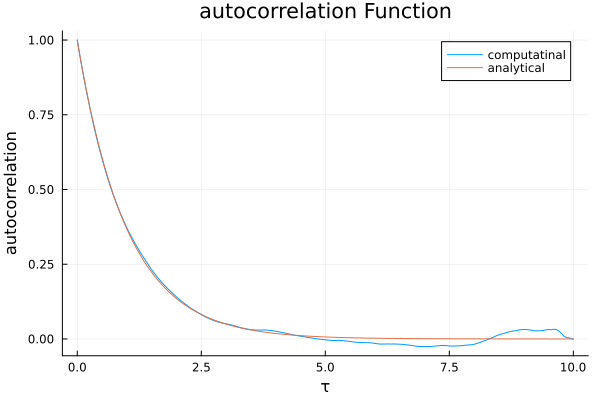

In [14]:
# Plot the autocorrelation function
n = max_lag+1
plot(times[1:n], autocorrelation[1:n], xlabel="τ", ylabel="autocorrelation", title="autocorrelation Function",label="computatinal")
plot!(times[1:n], analytical_autocorrelation[1:n], label="analytical")

## 10. Autocorrelation Function Approach Two

### Function to compute the covariance matrix

This function takes a matrix of trajectories as input and computes the covariance matrix. Each column of the `trajectories_matrix` represents a trajectory at different time points.

#### Parameters:
- `trajectories_matrix`: A matrix where each column represents a trajectory of the simulated process.

Returns the covariance matrix of the trajectoriesmatrix)
end


In [15]:
# Function to compute the covariance matrix
function compute_covariance_matrix(trajectories_matrix)
    return cov(trajectories_matrix)
end

compute_covariance_matrix (generic function with 1 method)

### Function to Compute the Empirical Autocorrelation Function from the Matrix

This function computes the empirical Autocorrelation function from a given covariance matrix. It calculates the covariance for each lag up to `max_lag` by averaging the covariances over all time points and finaly gets devided by the first element in the array.

#### Parameters:
- `cov_matrix`: The covariance matrix where each element represents the covariance between pairs of time points.
- `max_lag`: The maximum lag for which the covariance function is to be computed.

#### Returns:
- A vector containing the empirical autocorrelation values for each lag from 0 to `max_lag`.

#### Explanation 

In time series analysis, the covariance at a lag \(\tau\) represents how much two values of the series, separated by \(\tau\) time steps, vary together. To compute this from the covariance matrix:

1. **Covariance Matrix Definition**: 
   - The covariance matrix \(C\) is a square matrix where each element \(C_{i,j}\) represents the covariance between the time points \(i\) and \(j\) in the time series.
   - The diagonal elements \(C_{i,i}\) represent the variance at time point \(i\).

2. **Covariance at Lag \(\tau\)**:
   - For a given lag \(\tau\), the covariance is calculated by averaging the covariances of all pairs of time points \((i, i+\tau)\) across all trajectories.
   - Mathematically, this is given by:
     $$
     \text{Covariance}(\tau) = \frac{1}{n - \tau} \sum_{i=1}^{n-\tau} C_{i, i+\tau}
     $$
     where \(n\) is the number of time points in the series.

3. **Implementation**:
   - In the function, we iterate over each lag \(\tau\) from 0 to `max_lag`.
   - For each \(\tau\), the covariance \(\text{Cov}(\tau)\) is computed by summing the elements \(C_{i, i+\tau}\) for all valid \(i\), and then normalizing by the number of pairs \((i, i+\tau)\), i
   - we divide the final array by the first element in the array.e., \(n - \tau\).

4. **Result**:
   - The oautocorrelationvector of covariances for each lag \(\tau\) from 0 to `max_lag`, which can be used to analyze how the dependencies in the time series diminish as the lag increases.

This method provides a direct wayautocorrelation the lagged covariances from the covariance matrix, making it computationally efficient and easy to implement for large datasets.


In [16]:
# Compute the empirical covariance function from the matrix
function autocorrelation_function_from_matrix(cov_matrix, max_lag)
    n = size(cov_matrix, 1)  # number of time points
    covariances = Vector{Float64}(undef, max_lag + 1)
    
    for τ in 0:max_lag
        cov_τ = 0.0
        for t in 1:(n - τ)
            cov_τ += cov_matrix[t, t + τ]
        end
        covariances[τ + 1] = cov_τ / (n - τ)
    end
    
    return covariances
end

autocorrelation_function_from_matrix (generic function with 1 method)

## 11. Calculate and Plot Autocorrelation for Approach Two

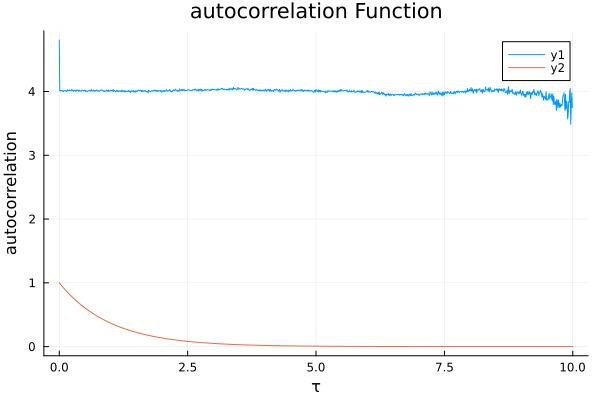

In [17]:
# Calculate the covariance matrix
cov_matrix = compute_covariance_matrix(trajectories_matrix)

# Calculate the autocorrelation function
autocorrelation = autocorrelation_function_from_matrix(cov_matrix, max_lag)

plot(times[1:max_lag+1], autocorrelation, xlabel="τ", ylabel="autocorrelation", title="autocorrelation Function")
plot!(times[1:max_lag+1], analytical_autocorrelation)

In [14]:
# Define the OUFixedEnsemble_2 function
function OUFixedEnsemble_2(θ, μ, σ, u0, tspan, dt, solver, samp, reltol, abstol)

    function f(du, u, p, t)
        du[1] = θ[1]*(μ[1] - u[1])
        du[2] = θ[2]*(μ[2] - u[2]) + σ[2]*u[1]
    end

    function g(du, u, p, t)
        du[1] = σ[1]
        du[2] = 0
    end
    
    prob = SDEProblem(f, g, u0, tspan)
    ensembleprob = EnsembleProblem(prob)
    sim = solve(ensembleprob, dt=dt, solver, EnsembleThreads(), trajectories=samp, abstol=abstol, reltol=reltol)
    return sim
end


OUFixedEnsemble_2 (generic function with 1 method)

In [20]:
θ = [1, 1]
μ = [0.0, 0.0]
σ = [sqrt(2), sqrt(2)]
u0 = [0, 10.0]
tf = 10
tspan = (0.0, tf)
saveint = 0.01
solver = EM()
samples = 10000
reltol = 1.0 * 10^(-6)
absol = 1.0 * 10^(-6)

1.0e-6

In [21]:
# Run the simulation
sim = OUFixedEnsemble_2(θ, μ, σ, u0, tspan, saveint, solver, samples, reltol, absol)

EnsembleSolution Solution of length 10000 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), Nothing, true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, SciMLBase.NullParameters, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, var"#f#9"{Vector{Int64}, Vector{Float64}, Vector{Float64}}, var"#g#10"{Vector{Float64}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, var"#g#10"{Vector{Flo

In [28]:
sim_y = []
for i in 1:length(sim)
    traj_y = []
    for j in 1:length(sim[1])
        append!(traj_y,sim[i][j][2])
    end
    print(traj_y)
    append!(sim_y,[traj_y])
end
sim_x = []
for i in 1:length(sim)
    traj_x = []
    for j in 1:length(sim[1])
        append!(traj_x,sim[i][j][1])
    end
    print(traj_x)
    append!(sim_x,[traj_x])
end

Any[10.0, 9.9, 9.799815779854457, 9.703817310301078, 9.609243507688975, 9.514789235621079, 9.424432047377874, 9.337264736436499, 9.249731248440996, 9.159643034091314, 9.071346553781058, 8.98244078257374, 8.895708127386643, 8.807420263863232, 8.721495583205186, 8.634628954753111, 8.545705606733229, 8.454657204607326, 8.366031922483312, 8.276833635481902, 8.187926485122494, 8.099385512259742, 8.013307116353088, 7.9268213589537995, 7.839794537017436, 7.753002499595087, 7.666342790226592, 7.583151429580543, 7.498611182406085, 7.4155593603972, 7.330724255423648, 7.249237546417953, 7.168458377408147, 7.086425387026213, 7.00258365013082, 6.9170202235218925, 6.834057145291139, 6.750736908574096, 6.668845212495137, 6.590670049006537, 6.513146080667164, 6.442460422621178, 6.375797688222177, 6.311694631246347, 6.244710721276903, 6.177351225602107, 6.1114237057922844, 6.0444699642630955, 5.977995325372009, 5.909592424310053, 5.845919598589489, 5.785759138724144, 5.7253914023315655, 5.6638133774266

Excessive output truncated after 524305 bytes.

, -0.4208526835233052, -0.4288550957454463, -0.4393584452683157, -0.4498547203857257, -0.462025182793385, -0.4746575681664107, -0.48652443187501543, -0.4968540626599698, -0.5049412482791528, -0.5132763913322543, -0.5215804032383596, -0.5310497054458214, -0.5387021305022148, -0.5458298052285678, -0.5567446876519558, -0.5698805317899751, -0.5842212606277454, -0.5962283708599737, -0.6078398949832281, -0.6183141079295048, -0.6259549333766727, -0.6381499116155455, -0.6499103659765259, -0.6556416551725918, -0.6604186641601919, -0.6651042184001581, -0.6719952785083847, -0.6805631518941357, -0.6879071936757406, -0.6932489065017088, -0.6988270246889987, -0.7062510039236519, -0.7157368882703616, -0.7253333220685345, -0.7325245924008326, -0.74193996768095, -0.7490814710017505, -0.7550784271775497, -0.7597820485690091, -0.7626549986957475, -0.764916572561961, -0.7648992197334912, -0.7687547406194558, -0.7720701502005085, -0.7742177268259152, -0.773469816518796, -0.7741717719737459, -0.773247414210

In [29]:
y_mean = []
for i in 1:length(sim_y[1])
    y = 0
    for j in 1:length(sim_y)
        y += sim_y[j][i]
    end
    append!(y_mean,y)
end
y_mean = y_mean/length(sim_y)
x_mean = []
for i in 1:length(sim_x[1])
    x = 0
    for j in 1:length(sim_x)
        x += sim_x[j][i]
    end
    append!(x_mean,x)
end
x_mean = x_mean/length(sim_x)

1001-element Vector{Float64}:
 0.0
 0.0006929043491802926
 0.0023090290828929093
 0.0033612225507393405
 0.0036788112613159387
 0.0027765837877565705
 0.004834194971059039
 0.00628199696662156
 0.004274579711064006
 0.003303738562621038
 0.004235887116605798
 0.004357073875384326
 0.00482563392789161
 ⋮
 0.01046486432907727
 0.010318085940859426
 0.010137969588733045
 0.008090452101039224
 0.008461684006728224
 0.007322044581083031
 0.006713183074878858
 0.007330262636654848
 0.00890504646487218
 0.010803722128418155
 0.010946737048228947
 0.010166709075950593

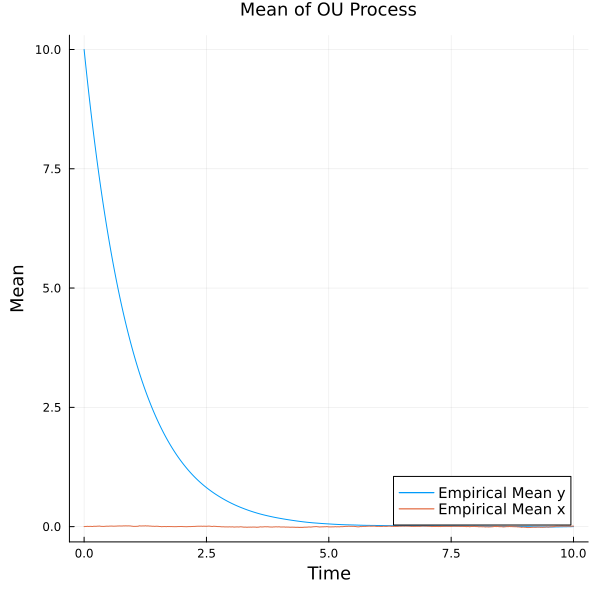

In [30]:
# Calculate the time for each mean
times = collect(range(0, step=saveint, length=length(y_mean)))


# Plot the empirical mean and the analytical mean
plot(times, y_mean, label="Empirical Mean y", xlabel="Time", ylabel="Mean", title="Mean of OU Process", legend=:bottomright, size=(600, 600), legendfontsize=10, titlefontsize=12, guidefontsize=12)
plot!(times, x_mean, label="Empirical Mean x")

In [31]:
trajectories_matrix_y = hcat(sim_y...)
trajectories_matrix_x = hcat(sim_x...)

1001×10000 Matrix{Float64}:
  0.0         0.0          0.0         …   0.0         0.0          0.0
 -0.083737    0.0497604    0.0353212      -0.149101   -0.12629     -0.045765
  0.141399    0.122618     0.165756       -0.0798383   0.00518356  -0.176244
  0.174257    0.282455     0.238283       -0.0619286   0.0369734   -0.26114
  0.115836    0.101274     0.119813       -0.208887   -0.249461    -0.620575
  0.338754    0.063086     0.0783909   …  -0.206301   -0.310622    -0.627742
  0.50042     0.0520304   -0.0273944      -0.199363   -0.467595    -0.968394
  0.412891   -0.00902889   0.0266119      -0.471217   -0.752932    -0.961296
  0.170349    0.0835016    0.061608       -0.693762   -0.962358    -0.977494
  0.233342    0.0947837   -0.0224252      -0.615553   -1.02841     -1.13827
  0.127823    0.0881893    0.232327    …  -0.799831   -1.0472      -1.31838
  0.21862    -0.0650267    0.180657       -0.590072   -1.00386     -1.35308
  0.0473208  -0.0532665    0.304384       -0.495379   -0.

In [32]:
# Calculate the maximum value for τ
max_lag = length(times) - 1

1000

In [33]:
# Calculate the computational autocorrelation for each tau
autocorrelation_y = autocorrelation_function(trajectories_matrix_y, y_mean, max_lag)
autocorrelation_x = autocorrelation_function(trajectories_matrix_x, x_mean, max_lag)

1001-element Vector{Float64}:
  1.0
  0.9900020306672548
  0.9801120175770908
  0.9703180908396989
  0.9606285575928115
  0.9510402095456904
  0.9415571064283318
  0.9321755567826789
  0.9228955018219487
  0.9137065792624893
  0.9046050226223313
  0.8955972448069991
  0.8866727860305611
  ⋮
 -0.0001019258018489173
 -0.0002273172176853089
 -0.0005083868562316171
 -0.0004813578381239339
 -0.0006012661352562494
 -0.0004327346299383238
 -0.00036925586599368364
 -0.0003345444004067459
 -6.890898841905835e-5
  0.00016041311290086163
  0.00023589351061198795
  0.0

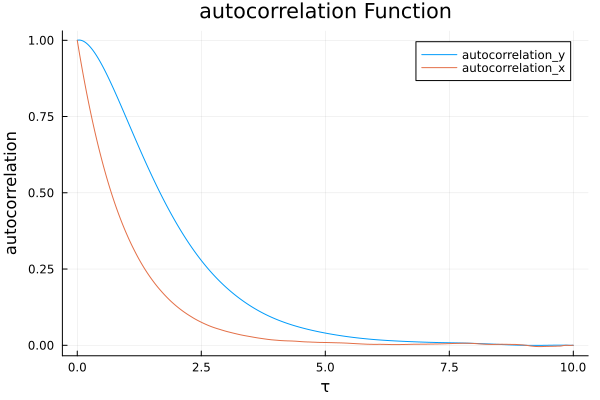

In [34]:
# Plot the autocorrelation function
n = max_lag+1
plot(times[1:n], autocorrelation_y[1:n], label="autocorrelation_y", xlabel="τ", ylabel="autocorrelation", title="autocorrelation Function")
plot!(times[1:n], autocorrelation_x[1:n], label="autocorrelation_x")